In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gco

In [2]:
K1 = np.array(
    [[1221.2270770, 0.0000000, 479.5000000], [0.0000000, 1221.2270770, 269.5000000], [0.0000000, 0.0000000, 1.0000000]])
K2 = np.array(
    [[1221.2270770, 0.0000000, 479.5000000], [0.0000000, 1221.2270770, 269.5000000], [0.0000000, 0.0000000, 1.0000000]])
R1 = np.array([[1.0000000000, 0.0000000000, 0.0000000000], [0.0000000000, 1.0000000000, 0.0000000000],
               [0.0000000000, 0.0000000000, 1.0000000000]])
R2 = np.array([[0.9998813487, 0.0148994942, 0.0039106989], [-0.0148907594, 0.9998865876, -0.0022532664],
               [-0.0039438279, 0.0021947658, 0.9999898146]])
T1 = np.array([[0.0000000000], [0.0000000000], [0.0000000000]])
T2 = np.array([[-9.9909793759], [0.2451742154], [0.1650832670]])

disparity = np.arange(0, 0.01, 0.01 / 65)

d_num = len(disparity)

img1 = cv.imread('data/test00.jpg')
img1 = img1[:, :, [2, 1, 0]]
img2 = cv.imread('data/test09.jpg')
img2 = img2[:, :, [2, 1, 0]]
H, W, C = img1.shape
tm2 = np.dot(np.dot(np.dot(K2, R2.T), R1), np.linalg.inv(K1))

tm1 = np.dot(np.dot(K2, R2.T), (T1 - T2))

p_h_x = np.tile(np.arange(W)[:, np.newaxis], [1, H]).T.reshape(1, -1)
p_h_y = np.tile(np.arange(H)[:, np.newaxis], [1, W]).reshape(1, -1)

x_h = np.concatenate((p_h_x, p_h_y, np.ones(H * W).reshape(1, -1)), axis=0)
x_h_norm = x_h.astype(int)
x_h_tm = np.dot(tm2, x_h)
x_h_f = np.tile(x_h[:, :, np.newaxis], [1, 1, d_num])
for i in range(d_num):
    d_add = disparity[i] * tm1
    # d_add_tile = np.tile(d_add[:,:],[1,H*W])
    x_h_f[:, :, i] = x_h_tm + d_add


In [3]:
def get_smooth(d_num):
    smooth = np.zeros((d_num, d_num))
    # smooth = 1-np.eye(d_number)
    for i in range(d_num):
        for j in range(d_num):
            if i != j:
                smooth[i][j] = abs(i - j)
    return smooth


# smooth = np.zeros((d_num, d_num))
# smooth = 1-np.eye(d_number)


def lse(p1, p2):
    return (abs(int(p1[0]) - int(p2[0])) + abs(int(p1[1]) - int(p2[1])) + abs(int(p1[2]) - int(p2[2]))) / 20


# maxunary = 0
unary = np.zeros((H, W, d_num))
for i in range(H):
    for j in range(W):
        x, y = x_h_norm[0:2, i * W + j]
        for k in range(d_num):
            x_1, y_1, z_1 = x_h_f[:, i * W + j, k]
            x_1 = int(x_1 / z_1)
            y_1 = int(y_1 / z_1)
            if 0 <= x_1 < W and 0 <= y_1 < H:
                unary[y, x, k] = lse(img1[y, x, :], img2[y_1, x_1, :])
                # maxunary = max(unary[y, x, k], maxunary)

# unary = unary/maxunary

In [4]:
smooth = get_smooth(d_num)
labels = gco.cut_grid_graph_simple(unary, smooth * 0.1, connect=8, n_iter=-1)
labels = labels.reshape(H, W)

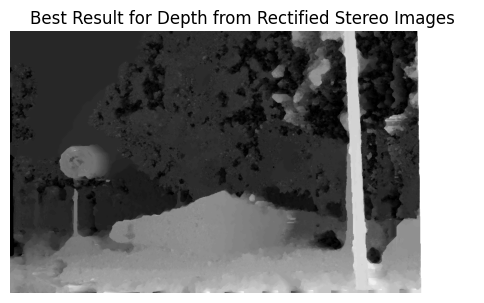

In [5]:
plt.figure(num=1, dpi=100, figsize=(6, 6))
plt.imshow(labels, cmap='gray')
plt.title('Best Result for Depth from Rectified Stereo Images')
plt.axis("off")
plt.show()